# Fully-Connected Neural Networks

## Setup

run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

In [4]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the CIFAR-10 dataset

The utility function `preprocess_cifar10()` returns the entire CIFAR-10 dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

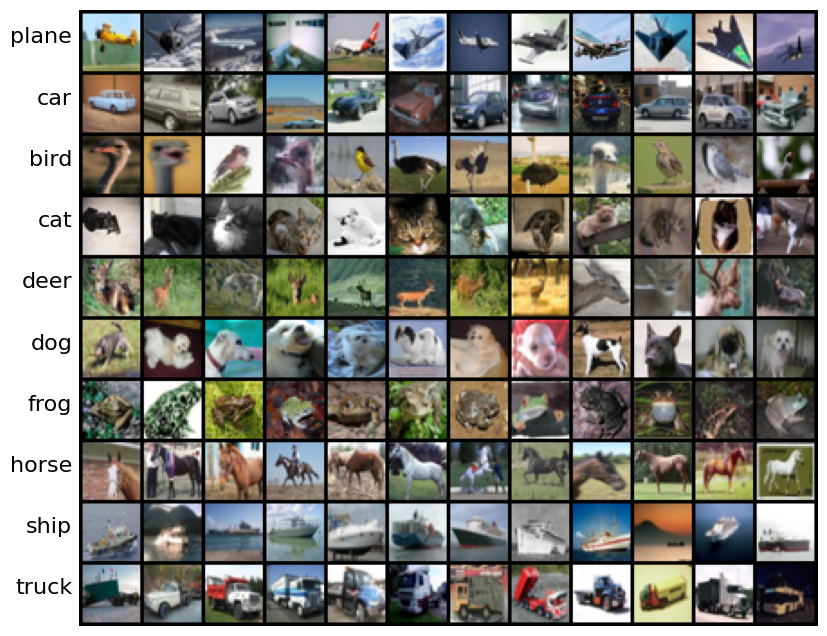

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [5]:
from fully_connected_networks import preprocess_cifar10

data_dict = preprocess_cifar10(cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

## Fully-connected neural networks
Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

We will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer as a tool to more efficiently optimize deep networks.

To validate our implementation, we will compare the analytically computed gradients with numerical approximations of the gradient as done in previous assignments.  

## Linear layer

For each layer we implement, we will define a class with two static methods `forward` and `backward`. The class structure is  in `fully_connected_layers.py` .

### Linear layer: forward

the `Linear.forward` function in `fully_connected_layers.py`. 

### Linear layer: backword

the `Linear.backward` function and test the implementation using numeric gradient checking. 

In [6]:
from fully_connected_networks import Linear,compute_numeric_gradient,rel_error

x = torch.randn(10, 2, 3, dtype=torch.float64, device='cuda')
w = torch.randn(6, 5, dtype=torch.float64, device='cuda')
b = torch.randn(5, dtype=torch.float64, device='cuda')
dout = torch.randn(10, 5, dtype=torch.float64, device='cuda')

dx_num = compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear.backward function:
dx error:  5.170864758949246e-10
dw error:  3.293741405059995e-10
db error:  5.373171200544344e-10


## ReLU activation

### ReLU activation: forward

 the forward pass for the ReLU activation function in the `ReLU.forward` function. 

### ReLU activation: backward
the backward pass for the ReLU activation function.

In [11]:
from fully_connected_networks import ReLU

x = torch.randn(10, 10, dtype=torch.float64, device='cuda')
dout = torch.randn(*x.shape, dtype=torch.float64, device='cuda')

dx_num = compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

print('Testing ReLU.backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  2.6317791621268993e-10


## "Sandwich" layers
linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.

run the following to numerically gradient check the `Linear_ReLU` backward pass.

In [27]:
from fully_connected_networks import Linear_ReLU

x = torch.randn(2, 3, 4, dtype=torch.float64, device='cuda')
w = torch.randn(12, 10, dtype=torch.float64, device='cuda')
b = torch.randn(10, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 10, dtype=torch.float64, device='cuda')

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ',rel_error(dx_num, dx))
print('dw error: ',rel_error(dw_num, dw))
print('db error: ',rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  8.389188100391279e-10
dw error:  1.4517097142003296e-09
db error:  9.614663496134104e-10


## Loss layers: Softmax and SVM
function `svm_loss` and `softmax_loss` in the file `fully_connected_networks.py`

Run the following to perform numeric gradient checking on the two loss functions

In [29]:
from fully_connected_networks import svm_loss, softmax_loss

num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

dx_num = compute_numeric_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. 
print('Testing svm_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

dx_num =compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. 
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.998484205267598
dx error:  2.0074935157654598e-08

Testing softmax_loss:
loss:  2.302433946012129
dx error:  1.1938964358700803e-07


## Two-layer network
implement the two layer network using these modular implementations. (class `TwoLayerNet` in the file `fully_connected_networks.py` )

In [30]:
from fully_connected_networks import TwoLayerNet,svm_loss, softmax_loss

N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

std = 1e-3
model = TwoLayerNet(
          input_dim=D,
          hidden_dim=H,
          num_classes=C,
          weight_scale=std,
          dtype=torch.float64,
          device='cuda'
        )

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D * H, dtype=torch.float64, device='cuda').reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, dtype=torch.float64, device='cuda')
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H * C, dtype=torch.float64, device='cuda').reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, dtype=torch.float64, device='cuda')
X = torch.linspace(-5.5, 4.5, steps=N * D, dtype=torch.float64, device='cuda').reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    dtype=torch.float64, device='cuda')
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.28e-07
W2 relative error: 1.45e-09
b1 relative error: 9.91e-07
b2 relative error: 4.99e-09
Running numeric gradient check with reg =  0.7
W1 relative error: 2.70e-08
W2 relative error: 1.07e-08
b1 relative error: 6.27e-07
b2 relative error: 2.72e-08


## Solver

Following a more modular design, now we split the logic for training models into a separate class. (class `Solver` in the file `fully_connected_networks.py` )

function `create_solver_networks` in the file `fully_connected_networks.py`

now use the Solver classes to create a solver instance that trains a TwoLayerNet 

In [31]:
from fully_connected_networks import create_solver_instance

solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cuda')
solver.train()

(Time 0.01 sec; Iteration 1 / 40000) loss: 2.302598
(Epoch 0 / 100) train acc: 0.129000; val_acc: 0.114500
(Time 0.23 sec; Iteration 11 / 40000) loss: 2.302522
(Time 0.27 sec; Iteration 21 / 40000) loss: 2.302530
(Time 0.31 sec; Iteration 31 / 40000) loss: 2.302629
(Time 0.35 sec; Iteration 41 / 40000) loss: 2.302484
(Time 0.39 sec; Iteration 51 / 40000) loss: 2.302068
(Time 0.43 sec; Iteration 61 / 40000) loss: 2.302700
(Time 0.47 sec; Iteration 71 / 40000) loss: 2.302580
(Time 0.51 sec; Iteration 81 / 40000) loss: 2.302140
(Time 0.55 sec; Iteration 91 / 40000) loss: 2.302187
(Time 0.59 sec; Iteration 101 / 40000) loss: 2.302419
(Time 0.63 sec; Iteration 111 / 40000) loss: 2.302538
(Time 0.67 sec; Iteration 121 / 40000) loss: 2.301971
(Time 0.71 sec; Iteration 131 / 40000) loss: 2.302333
(Time 0.75 sec; Iteration 141 / 40000) loss: 2.302493
(Time 0.79 sec; Iteration 151 / 40000) loss: 2.302006
(Time 0.83 sec; Iteration 161 / 40000) loss: 2.302513
(Time 0.87 sec; Iteration 171 / 40000)

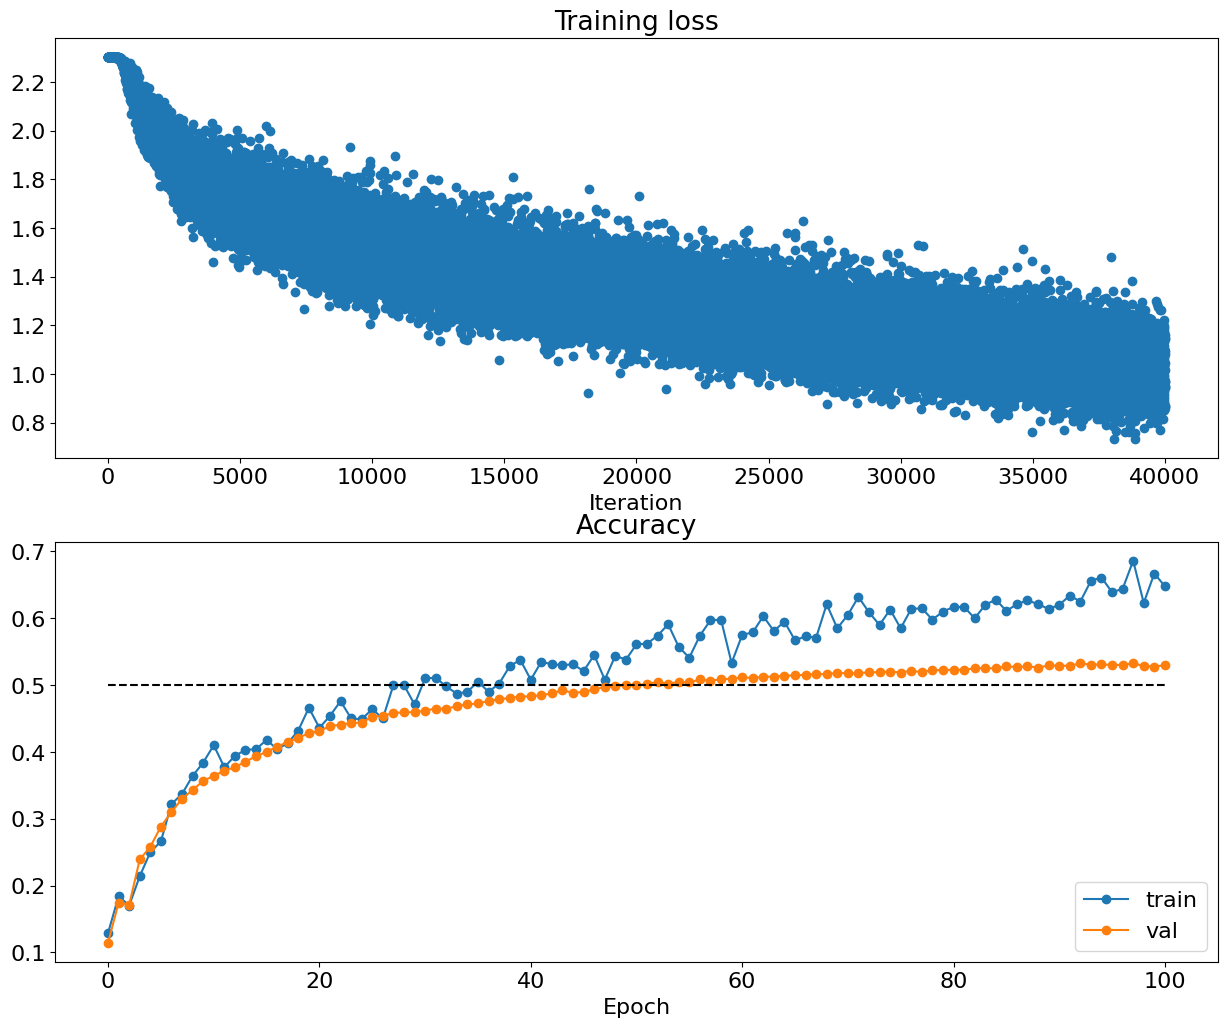

In [32]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [33]:
import os
path = os.path.join('../models', 'best_two_layer_net.pth')
solver.model.save(path)


from fully_connected_networks import create_solver_instance


solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cuda')

# Load model
solver.model.load(path, dtype=torch.float64, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_val, solver.y_val)
print(f"Saved model's accuracy on validation is {accuracy}")


Saved in ../models\best_two_layer_net.pth
load checkpoint file: ../models\best_two_layer_net.pth
Saved model's accuracy on validation is 0.5325999855995178


## Multilayer network

implement a fully-connected network with an arbitrary number of hidden layers.

the `FullyConnectedNet` class in `fully_connected_networks.py`. 

### Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. 

In [ ]:
from fully_connected_networks import FullyConnectedNet

N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2, 
        dtype=torch.float64, 
        device='cuda'
  )

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3053575717037686
W1 relative error: 6.06e-08
W2 relative error: 1.02e-07
W3 relative error: 5.89e-08
b1 relative error: 1.28e-07
b2 relative error: 2.05e-08
b3 relative error: 2.57e-09
Running check with reg =  3.14
Initial loss:  12.278358041494133
W1 relative error: 8.28e-09
W2 relative error: 6.35e-09
W3 relative error: 7.01e-09
b1 relative error: 3.18e-07
b2 relative error: 6.59e-08
b3 relative error: 1.63e-08


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

(Time 0.08 sec; Iteration 1 / 40) loss: 913.642456
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.119700
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.136500
(Epoch 2 / 20) train acc: 0.480000; val_acc: 0.141900
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.163200
(Epoch 4 / 20) train acc: 0.700000; val_acc: 0.154000
(Epoch 5 / 20) train acc: 0.860000; val_acc: 0.162600
(Time 0.32 sec; Iteration 11 / 40) loss: 24.834692
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.159600
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.151400
(Epoch 8 / 20) train acc: 0.960000; val_acc: 0.153200
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.147400
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.147400
(Time 0.47 sec; Iteration 21 / 40) loss: 0.000000
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.150600
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.150600
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.150600
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.150600
(Epoch 15 / 20) train acc: 1.0000

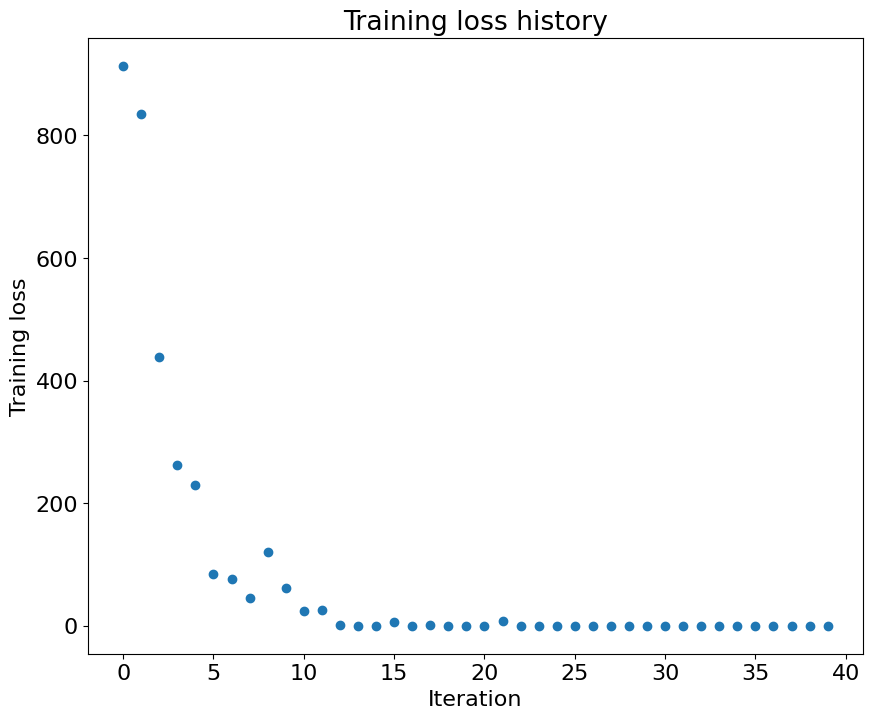

In [34]:
from fully_connected_networks import FullyConnectedNet,get_three_layer_network_params,Solver

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

weight_scale, learning_rate = get_three_layer_network_params()

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

(Time 0.00 sec; Iteration 1 / 40) loss: 3.770882
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.090700
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.110300
(Epoch 2 / 20) train acc: 0.580000; val_acc: 0.127700
(Epoch 3 / 20) train acc: 0.680000; val_acc: 0.135600
(Epoch 4 / 20) train acc: 0.820000; val_acc: 0.128000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.133000
(Time 0.49 sec; Iteration 11 / 40) loss: 0.626523
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.138400
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.145100
(Epoch 8 / 20) train acc: 0.980000; val_acc: 0.147500
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.141000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.149400
(Time 0.88 sec; Iteration 21 / 40) loss: 0.245273
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.144300
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.148600
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.148900
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.146100
(Epoch 15 / 20) train acc: 1.000000;

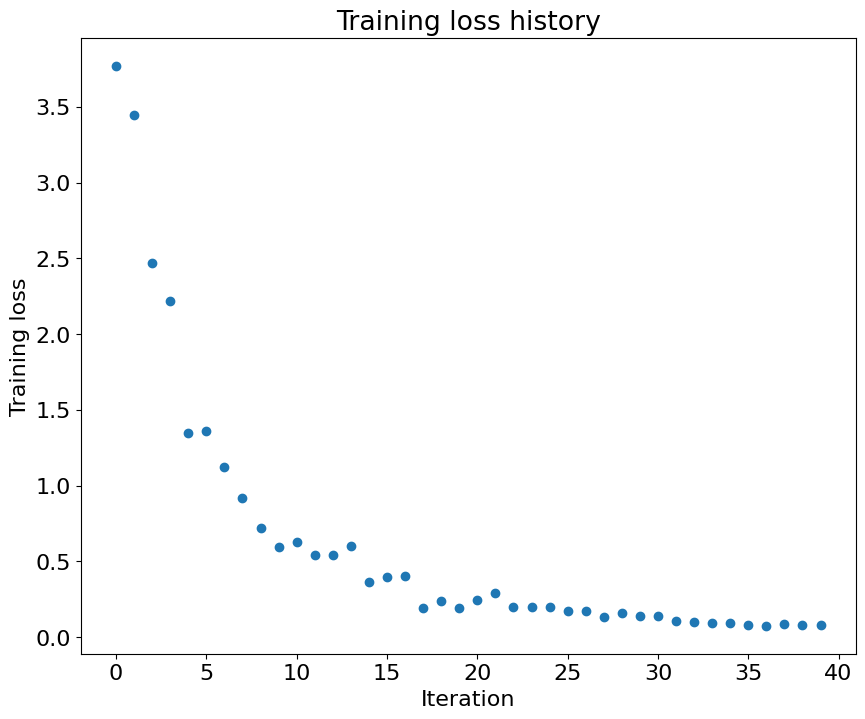

In [35]:
from fully_connected_networks import FullyConnectedNet, get_five_layer_network_params

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_five_layer_network_params()

# Run models and solver with parameters
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

In [ ]:
# Set path 
path = os.path.join('../models', 'best_overfit_five_layer_net.pth')
solver.model.save(path)

# Create a new instance  -- Note that hidden dims being different doesn't matter here.
model = FullyConnectedNet(hidden_dims=[100, ], dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )

# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
accuracy = solver.check_accuracy(solver.X_train, solver.y_train)
print(f"Saved model's accuracy on small train is {accuracy}")

Saved in ..\best_overfit_five_layer_net.pth
load checkpoint file: ..\best_overfit_five_layer_net.pth
Saved model's accuracy on small train is 1.0


## Update rules

### SGD+Momentum

So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

We will implement various first-order update rules that are commonly used
for training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:
```python
def update(w, dw, config=None):
Inputs:
  - w: A tensor giving the current weights.
  - dw: A tensor of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.
Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.
NOTE: For most update rules, the default learning rate will probably not
perform well; however the default values of the other hyperparameters should
work well for a variety of different problems.
For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
```
 the implementation of the SGD update rule  in `fully_connected_networks.py`

train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.



running with  sgd
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302740
(Epoch 0 / 5) train acc: 0.098000; val_acc: 0.094700
(Epoch 1 / 5) train acc: 0.121000; val_acc: 0.120500
(Epoch 2 / 5) train acc: 0.113000; val_acc: 0.103500
(Epoch 3 / 5) train acc: 0.109000; val_acc: 0.101000
(Epoch 4 / 5) train acc: 0.119000; val_acc: 0.115900
(Epoch 5 / 5) train acc: 0.166000; val_acc: 0.163400

running with  sgd_momentum
(Time 0.00 sec; Iteration 1 / 200) loss: 2.301932
(Epoch 0 / 5) train acc: 0.097000; val_acc: 0.100300
(Epoch 1 / 5) train acc: 0.122000; val_acc: 0.109300
(Epoch 2 / 5) train acc: 0.158000; val_acc: 0.162000
(Epoch 3 / 5) train acc: 0.202000; val_acc: 0.184800
(Epoch 4 / 5) train acc: 0.256000; val_acc: 0.233700
(Epoch 5 / 5) train acc: 0.267000; val_acc: 0.248700



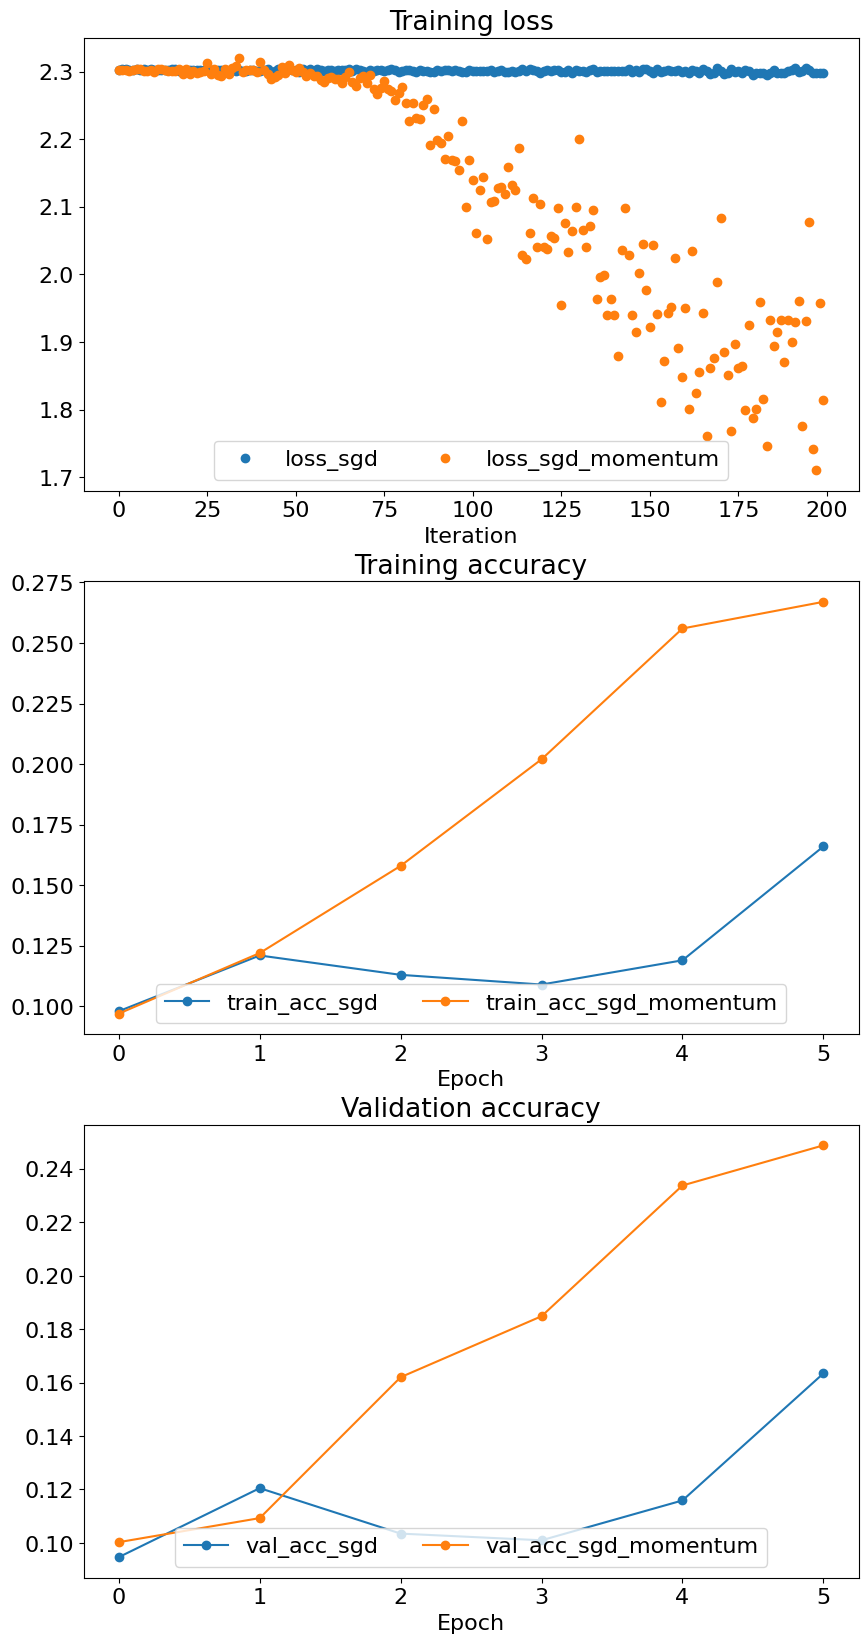

In [36]:
from fully_connected_networks import FullyConnectedNet, sgd, sgd_momentum

num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            dtype=torch.float32, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

### RMSProp

RMSProp [1] is an update rule that set per-parameter learning rates by using a running average of the second moments of gradients.

`rmsprop` function in `fully_connected_networks.py`. 

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

### Adam

Adam [2] extends RMSprop with a first-order gradient cache similar to momentum, and a bias correction mechanism to prevent large steps at the start of optimization. Adam is one of the most commonly used update rules used in practice for training deep neural networks.

 `adam` function in `fully_connected_networks.py`. 

the _complete_ Adam update rule (with the bias correction mechanism)

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

train a pair of deep networks using these new update rules

running with  sgd_momentum
(Time 0.03 sec; Iteration 1 / 200) loss: 2.302523
(Epoch 0 / 5) train acc: 0.101000; val_acc: 0.103200
(Epoch 1 / 5) train acc: 0.247000; val_acc: 0.219300
(Epoch 2 / 5) train acc: 0.357000; val_acc: 0.297400
(Epoch 3 / 5) train acc: 0.385000; val_acc: 0.329700
(Epoch 4 / 5) train acc: 0.391000; val_acc: 0.332100
(Epoch 5 / 5) train acc: 0.437000; val_acc: 0.355500

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302238
(Epoch 0 / 5) train acc: 0.114000; val_acc: 0.097200
(Epoch 1 / 5) train acc: 0.205000; val_acc: 0.210100
(Epoch 2 / 5) train acc: 0.260000; val_acc: 0.227900
(Epoch 3 / 5) train acc: 0.281000; val_acc: 0.241400
(Epoch 4 / 5) train acc: 0.252000; val_acc: 0.249600
(Epoch 5 / 5) train acc: 0.311000; val_acc: 0.263900



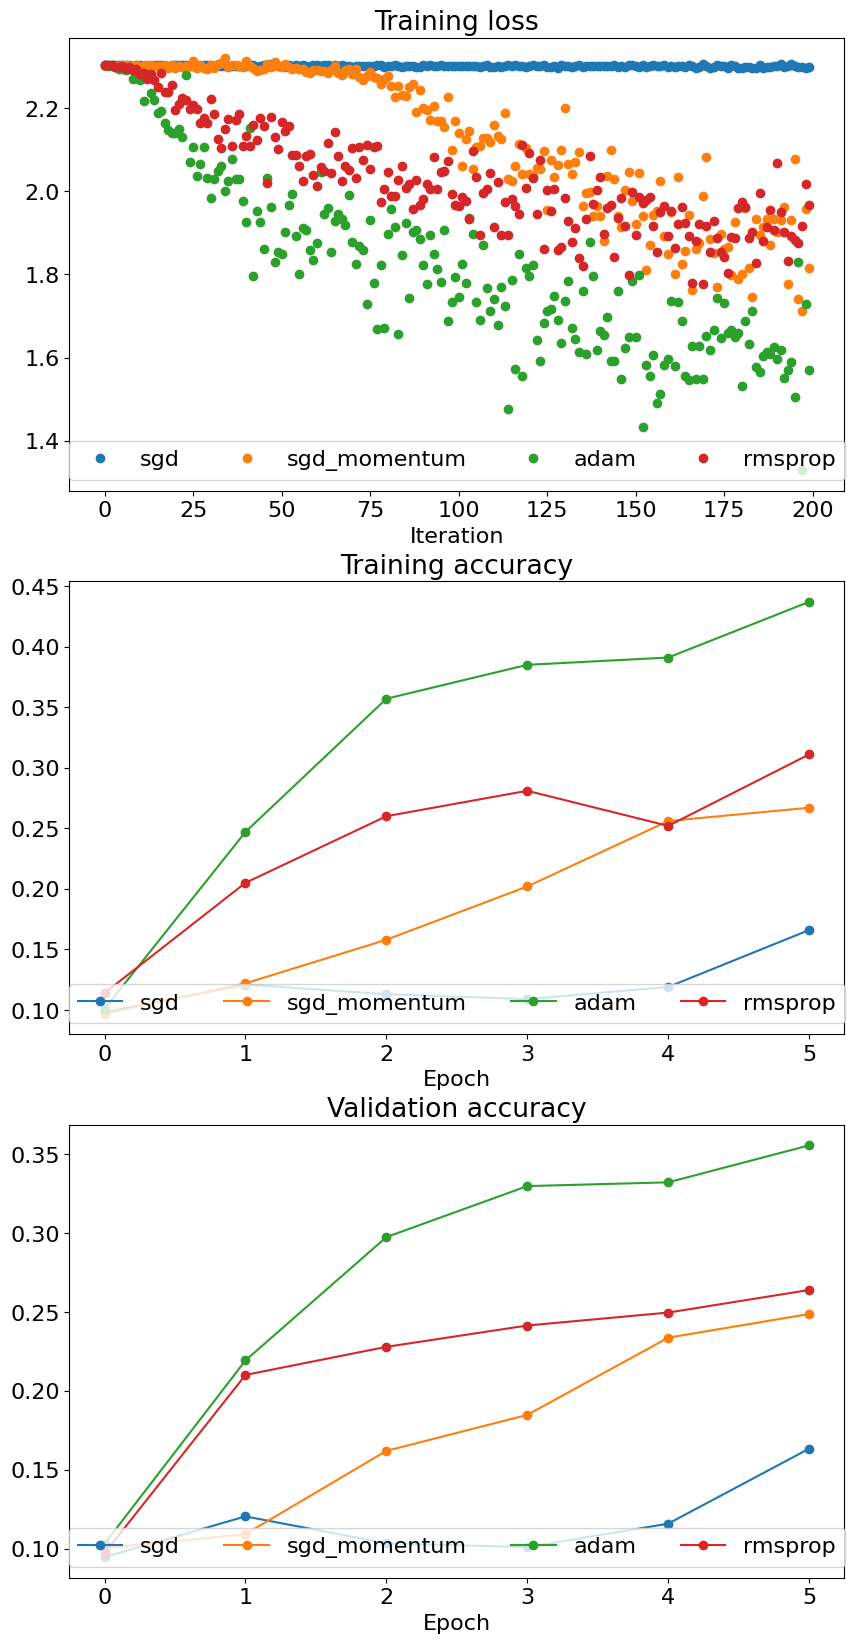

In [37]:
from fully_connected_networks import adam, rmsprop, FullyConnectedNet

for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

# Dropout

Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. Here we will implement a dropout layer and modify the fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

## Dropout: forward

dropout behaves differently during training and testing

The mean of the output should be approximately the same during training and testing. During training the number of outputs set to zero should be approximately equal to the drop probability `p`, and during testing no outputs should be set to zero.

In [39]:
from fully_connected_networks import Dropout

x = torch.randn(500, 500, dtype=torch.float64, device='cuda') + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

Running tests with p =  0.25
Mean of input:  10.003870866556383
Mean of train-time output:  9.994613221642103
Mean of test-time output:  10.003870866556383
Fraction of train-time output set to zero:  0.2506679892539978
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.003870866556383
Mean of train-time output:  10.038868473194812
Mean of test-time output:  10.003870866556383
Fraction of train-time output set to zero:  0.3977719843387604
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.003870866556383
Mean of train-time output:  9.997528885376312
Mean of test-time output:  10.003870866556383
Fraction of train-time output set to zero:  0.7002720236778259
Fraction of test-time output set to zero:  0.0



## Dropout: backward

run the following cell to numerically gradient-check the implementation

In [41]:
from fully_connected_networks import Dropout

x = torch.randn(10, 10, dtype=torch.float64, device='cuda') + 10
dout = torch.randn_like(x)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 0}
out, cache = Dropout.forward(x, dropout_param)
dx = Dropout.backward(dout, cache)
dx_num = compute_numeric_gradient(lambda xx: Dropout.forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  4.597345631736442e-09


# Fully-connected nets with dropout

Modify the implementation of `FullyConnectedNet` to use dropout. Specifically, if the constructor of the network receives a value that is not 0 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity.

run the following to numerically gradient-check the implementation.

In [42]:
from fully_connected_networks import FullyConnectedNet

N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dropout=dropout,
                            seed=0, dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num =compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.299510034168974
W1 relative error: 8.07e-08
W2 relative error: 8.12e-08
W3 relative error: 2.71e-08
b1 relative error: 1.55e-07
b2 relative error: 2.56e-08
b3 relative error: 1.74e-09

Running check with dropout =  0.25
Initial loss:  2.3029113306714013
W1 relative error: 6.16e-08
W2 relative error: 5.44e-08
W3 relative error: 2.24e-08
b1 relative error: 6.83e-08
b2 relative error: 1.41e-08
b3 relative error: 1.48e-09

Running check with dropout =  0.5
Initial loss:  2.3129887627677768
W1 relative error: 2.33e-08
W2 relative error: 3.82e-08
W3 relative error: 2.89e-08
b1 relative error: 4.57e-08
b2 relative error: 7.76e-09
b3 relative error: 1.57e-09



## Regularization experiment
To get a sense of the way that dropout can regularize a neural network, we will train three different two-layer networks:

1. Hidden size 256, dropout = 0
2. Hidden size 512, dropout = 0
3. Hidden size 512, dropout = 0.5

We will then visualize the training and validation accuracies of these three networks.

In [43]:
from fully_connected_networks import FullyConnectedNet

num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, dtype=torch.float32, device='cuda')
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device='cuda')
  solver.train()
  solvers[(dropout, width)] = solver
  print()

Training a model with dropout=0.00 and width=256
(Time 0.01 sec; Iteration 1 / 3900) loss: 2.303148
(Epoch 0 / 100) train acc: 0.195000; val_acc: 0.179900
(Epoch 10 / 100) train acc: 0.714000; val_acc: 0.472600
(Epoch 20 / 100) train acc: 0.821000; val_acc: 0.471700
(Epoch 30 / 100) train acc: 0.933000; val_acc: 0.473000
(Epoch 40 / 100) train acc: 0.964000; val_acc: 0.465100
(Epoch 50 / 100) train acc: 0.955000; val_acc: 0.466900
(Epoch 60 / 100) train acc: 0.972000; val_acc: 0.469400
(Epoch 70 / 100) train acc: 1.000000; val_acc: 0.478200
(Epoch 80 / 100) train acc: 0.843000; val_acc: 0.442000
(Epoch 90 / 100) train acc: 0.991000; val_acc: 0.471400
(Epoch 100 / 100) train acc: 1.000000; val_acc: 0.480900

Training a model with dropout=0.00 and width=512
(Time 0.00 sec; Iteration 1 / 3900) loss: 2.303685
(Epoch 0 / 100) train acc: 0.191000; val_acc: 0.217500
(Epoch 10 / 100) train acc: 0.763000; val_acc: 0.479400
(Epoch 20 / 100) train acc: 0.859000; val_acc: 0.462300
(Epoch 30 / 100)

If everything worked as expected, you should see that the network with dropout has lower training accuracies than the networks without dropout, but that it achieves higher validation accuracies.

You should also see that a network with width 512 and dropout 0.5 achieves higher validation accuracies than a network with width 256 and no dropout. This demonstrates that reducing the model size is not generally an effective regularization strategy -- it's often better to use a larger model with explicit regularization.

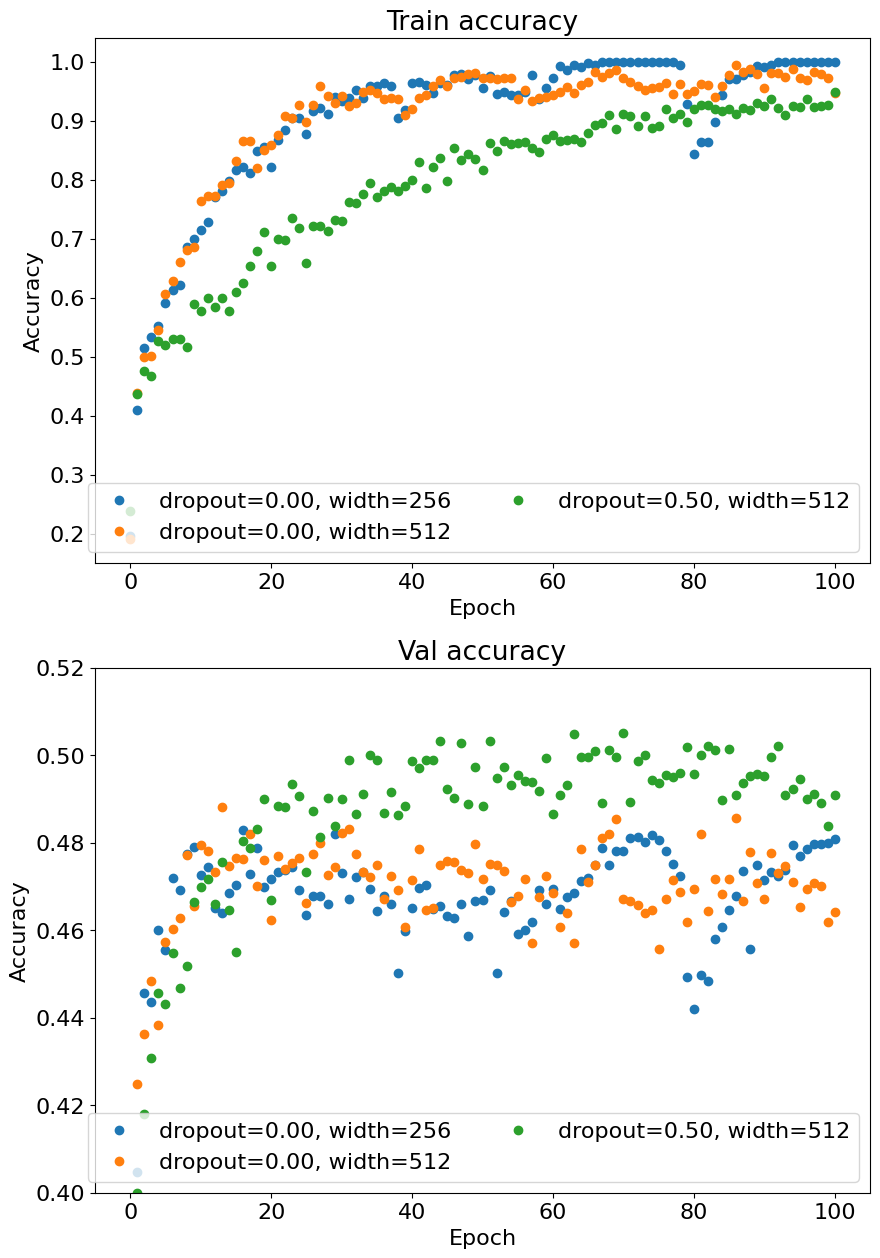

In [44]:
plt.subplot(2, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(2, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 15)
plt.show()